In [8]:
import numpy as np
import os
from scipy.signal import resample

In [9]:
os.chdir("C:\\Users/Bridget Leonard/Desktop/BridgeTower-Brain")

## Part 5: fMRI Prediction
- project features into opposite modal space with feature alignment
- predict fMRI activity using features

## 1 Feature alignment matrices

### 1.1 Load the matrices
These matrices were calculated in part 3. They represent the linear relationship between image and caption pairs. The image-->caption matrices were estimated by predicting each language feature from visual features, the caption--> image matrices were estimated by predicting each visual feature from the language features. Thus we have two matrices with size [768, 768] where each column represents a language or visual feature's linear relationship (beta coefficient) with each visual or language feature, respectively.

In [10]:
caption_to_image_matrices = np.load("results/feature_alignment/caption_to_image_matrices.npy")
image_to_caption_matrices = np.load("results/feature_alignment/image_to_caption_matrices.npy")

In [11]:
caption_to_image_matrices.shape

(768, 768)

### 1.2 Project data into the opposite modal space

In [12]:
# Load feature vectors
# movie data
test = np.load("results/feature_vectors/movie/test_data.npy")
train00 = np.load("results/feature_vectors/movie/train_00_data.npy")
train01 = np.load("results/feature_vectors/movie/train_01_data.npy")
train02 = np.load("results/feature_vectors/movie/train_02_data.npy")
train03 = np.load("results/feature_vectors/movie/train_03_data.npy")
train04 = np.load("results/feature_vectors/movie/train_04_data.npy")
train05 = np.load("results/feature_vectors/movie/train_05_data.npy")
train06 = np.load("results/feature_vectors/movie/train_06_data.npy")
train07 = np.load("results/feature_vectors/movie/train_07_data.npy")
train08 = np.load("results/feature_vectors/movie/train_08_data.npy")
train09 = np.load("results/feature_vectors/movie/train_09_data.npy")
train10 = np.load("results/feature_vectors/movie/train_10_data.npy")
train11 = np.load("results/feature_vectors/movie/train_11_data.npy")

# story data
alternateithicatom = np.load("results/feature_vectors/story/alternateithicatom_data.npy")
avatar = np.load("results/feature_vectors/story/avatar_data.npy")
howtodraw = np.load("results/feature_vectors/story/howtodraw_data.npy")
legacy = np.load("results/feature_vectors/story/legacy_data.npy")
life = np.load("results/feature_vectors/story/life_data.npy")
myfirstdaywiththeyankees = np.load("results/feature_vectors/story/myfirstdaywiththeyankees_data.npy")
naked = np.load("results/feature_vectors/story/naked_data.npy")
odetostepfather = np.load("results/feature_vectors/story/odetostepfather_data.npy")
souls = np.load("results/feature_vectors/story/souls_data.npy")
undertheinfluence = np.load("results/feature_vectors/story/undertheinfluence_data.npy")

Visual to text: Movie data

In [13]:
test_transformed = np.dot(test, image_to_caption_matrices.T)
train00_transformed = np.dot(train00, image_to_caption_matrices.T)
train01_transformed = np.dot(train01, image_to_caption_matrices.T)
train02_transformed = np.dot(train02, image_to_caption_matrices.T)
train03_transformed = np.dot(train03, image_to_caption_matrices.T)
train04_transformed = np.dot(train04, image_to_caption_matrices.T)
train05_transformed = np.dot(train05, image_to_caption_matrices.T)
train06_transformed = np.dot(train06, image_to_caption_matrices.T)
train07_transformed = np.dot(train07, image_to_caption_matrices.T)
train08_transformed = np.dot(train08, image_to_caption_matrices.T)
train09_transformed = np.dot(train09, image_to_caption_matrices.T)
train10_transformed = np.dot(train10, image_to_caption_matrices.T)
train11_transformed = np.dot(train11, image_to_caption_matrices.T)

Text to visual: Story data

In [14]:
alternateithicatom_transformed = np.dot(alternateithicatom, caption_to_image_matrices.T)
avatar_transformed = np.dot(avatar, caption_to_image_matrices.T)
howtodraw_transformed = np.dot(howtodraw, caption_to_image_matrices.T)
legacy_transformed = np.dot(legacy, caption_to_image_matrices.T)
life_transformed = np.dot(life, caption_to_image_matrices.T)
myfirstdaywiththeyankees_transformed = np.dot(myfirstdaywiththeyankees, caption_to_image_matrices.T)
naked_transformed = np.dot(naked, caption_to_image_matrices.T)
odetostepfather_transformed = np.dot(odetostepfather, caption_to_image_matrices.T)
souls_transformed = np.dot(souls, caption_to_image_matrices.T)
undertheinfluence_transformed = np.dot(undertheinfluence, caption_to_image_matrices.T)

## 2 Load voxelwise encoding models
These matrices were calculated in part 4.

### 2.1 Vision encoding model

In [15]:
vision_encoding = np.load("results/encoding_model/movie/S1_coefficients.npy")

In [16]:
vision_encoding.shape

(768, 81111)

In [17]:
np.all(vision_encoding == 0)

False

### 2.2 Language Encoding Model

In [18]:
language_encoding = np.load("results/encoding_model/story/S1_coefficients.npy")

In [19]:
language_encoding.shape

(768, 81111)

In [20]:
np.all(language_encoding == 0)

False

## 3 Using the vision encoding model to predict fMRI responses to stories
We'll be using the tranformed story data above to predict the fMRI data found in `data/fmri_data/storydata/S1`

### 3.1 Load fMRI data

In [21]:
s1_alternateithicatom = np.load("data/fmri_data/storydata/S1/alternateithicatom.npy")
s1_avatar = np.load("data/fmri_data/storydata/S1/avatar.npy")
s1_howtodraw = np.load("data/fmri_data/storydata/S1/howtodraw.npy")
s1_legacy = np.load("data/fmri_data/storydata/S1/legacy.npy")
s1_life = np.load("data/fmri_data/storydata/S1/life.npy")
s1_myfirstdaywiththeyankees = np.load("data/fmri_data/storydata/S1/myfirstdaywiththeyankees.npy")
s1_naked = np.load("data/fmri_data/storydata/S1/naked.npy")
s1_odetostepfather = np.load("data/fmri_data/storydata/S1/odetostepfather.npy")
s1_souls = np.load("data/fmri_data/storydata/S1/souls.npy")
s1_undertheinfluence = np.load("data/fmri_data/storydata/S1/undertheinfluence.npy")

In [22]:
from bridgetower_functions import prep_data

c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Prep data
s1_ai_fmri, ai_features = prep_data(s1_alternateithicatom, alternateithicatom_transformed)
s1_avatar_fmri, avatar_features = prep_data(s1_avatar, avatar_transformed)
s1_howtodraw_fmri, howtodraw_features = prep_data(s1_howtodraw, howtodraw_transformed)
s1_legacy_fmri, legacy_features = prep_data(s1_legacy, legacy_transformed)
s1_life_fmri, life_features = prep_data(s1_life, life_transformed)
s1_yankees_fmri, yankees_features = prep_data(s1_myfirstdaywiththeyankees, myfirstdaywiththeyankees_transformed)
s1_naked_fmri, naked_features = prep_data(s1_naked, naked_transformed)
s1_odetostepfather_fmri, odetostepfather_features = prep_data(s1_odetostepfather, odetostepfather_transformed)
s1_souls_fmri, souls_features = prep_data(s1_souls, souls_transformed)
s1_undertheinfluence_fmri, undertheinfluence_features = prep_data(s1_undertheinfluence, undertheinfluence_transformed)

fMRI shape: (363, 81111)
Shape after resampling: (363, 768)
fMRI shape: (387, 81111)
Shape after resampling: (387, 768)
fMRI shape: (374, 81111)
Shape after resampling: (374, 768)
fMRI shape: (420, 81111)
Shape after resampling: (420, 768)
fMRI shape: (450, 81111)
Shape after resampling: (450, 768)
fMRI shape: (378, 81111)
Shape after resampling: (378, 768)
fMRI shape: (442, 81111)
Shape after resampling: (442, 768)
fMRI shape: (424, 81111)
Shape after resampling: (424, 768)
fMRI shape: (375, 81111)
Shape after resampling: (375, 768)
fMRI shape: (324, 81111)
Shape after resampling: (324, 768)


### 3.2 Keep scans individual
Because each of our scans are different lengths we want to go through the prediction and correlation process with each of them individually. This way, a longer scan will not overrepresent the correlation between model predictions and actual data

In [24]:
s1_ai_predictions = np.dot(ai_features, vision_encoding)
s1_avatar_predictions = np.dot(avatar_features, vision_encoding)
s1_howtodraw_predictions = np.dot(howtodraw_features, vision_encoding)
s1_legacy_predictions = np.dot(legacy_features, vision_encoding)
s1_life_predictions = np.dot(life_features, vision_encoding)
s1_yankees_predictions = np.dot(yankees_features, vision_encoding)
s1_naked_predictions = np.dot(naked_features, vision_encoding)
s1_odetostepfather_predictions = np.dot(odetostepfather_features, vision_encoding)
s1_souls_predictions = np.dot(souls_features, vision_encoding)
s1_undertheinfluence_predictions = np.dot(undertheinfluence_features, vision_encoding)


In [25]:
from bridgetower_functions import calc_correlation

In [26]:
s1_ai_correlations = calc_correlation(s1_ai_predictions, s1_ai_fmri)
s1_avatar_correlations = calc_correlation(s1_avatar_predictions, s1_avatar_fmri)
s1_howtodraw_correlations = calc_correlation(s1_howtodraw_predictions, s1_howtodraw_fmri)
s1_legacy_correlations = calc_correlation(s1_legacy_predictions, s1_legacy_fmri)
s1_life_correlations = calc_correlation(s1_life_predictions, s1_life_fmri)
s1_yankees_correlations = calc_correlation(s1_yankees_predictions, s1_yankees_fmri)
s1_naked_correlations = calc_correlation(s1_naked_predictions, s1_naked_fmri)
s1_odetostepfather_correlations = calc_correlation(s1_odetostepfather_predictions, s1_odetostepfather_fmri)
s1_souls_correlations = calc_correlation(s1_souls_predictions, s1_souls_fmri)
s1_undertheinfluence_correlations = calc_correlation(s1_undertheinfluence_predictions, s1_undertheinfluence_fmri)

NaNs in correlation coefficients: True
NaNs in correlation coefficients: True
NaNs in correlation coefficients: False
NaNs in correlation coefficients: False
NaNs in correlation coefficients: False
NaNs in correlation coefficients: True
NaNs in correlation coefficients: True
NaNs in correlation coefficients: True
NaNs in correlation coefficients: True
NaNs in correlation coefficients: False


In [27]:
all_correlations = np.stack((s1_ai_correlations, s1_avatar_correlations, s1_howtodraw_correlations,
                             s1_legacy_correlations, s1_life_correlations, s1_yankees_correlations,
                             s1_naked_correlations, s1_odetostepfather_correlations, s1_souls_correlations,
                             s1_undertheinfluence_correlations))

s1_story_correlations = np.nanmean(all_correlations, axis=0)
np.nanmax(s1_story_correlations)

0.13125361072415015

### 3.4 Visualize the correlation coefficients

#### 3.4.1 Reverse flattening and masking

In [28]:
s1_alternateithicatom.shape

(363, 31, 100, 100)

In [29]:
# Recreate the mask used for flattening (assuming you have access to 's1_movie_train' or similar)
mask = ~np.isnan(s1_alternateithicatom[0])  # Using the first time point as a reference for the mask

# Initialize an empty 3D array with NaNs for the correlation data
s1_story_reconstructed_correlations = np.full((31, 100, 100), np.nan)

# Flatten the mask to get the indices of the original valid (non-NaN) data points
valid_indices = np.where(mask.flatten())[0]

# Assign the correlation coefficients to their original spatial positions
for index, corr_value in zip(valid_indices, s1_story_correlations):
    # Convert the 1D index back to 3D index in the spatial dimensions
    z, x, y = np.unravel_index(index, (31, 100, 100))
    s1_story_reconstructed_correlations[z, x, y] = corr_value

s1_story_reconstructed_correlations.shape

(31, 100, 100)

In [30]:
s1_story_flattened_correlations = s1_story_reconstructed_correlations.flatten()
s1_story_flattened_correlations.shape

(310000,)

In [31]:
np.nanmax(s1_story_flattened_correlations)

0.13125361072415015

#### 3.4.2 Plot the correlations

In [32]:
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

In [33]:
# Load the vertex-to-voxel mapping for a hemisphere
s1_lh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_lh.npz")
s1_lh_mapping_matrix.shape

(151191, 310000)

In [34]:
s1_story_lh_vertex_correlation_data = s1_lh_mapping_matrix.dot(s1_story_flattened_correlations)
s1_lh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_lh.npy")

In [35]:
# Load the vertex-to-voxel mapping for a hemisphere
s1_rh_mapping_matrix = load_npz("data/fmri_data/mappers/S1_listening_forVL_rh.npz")
s1_rh_mapping_matrix.shape

(152632, 310000)

In [36]:
s1_story_rh_vertex_correlation_data = s1_rh_mapping_matrix.dot(s1_story_flattened_correlations)
s1_rh_vertex_coords = np.load("data/fmri_data/mappers/S1_vertex_coords_rh.npy")

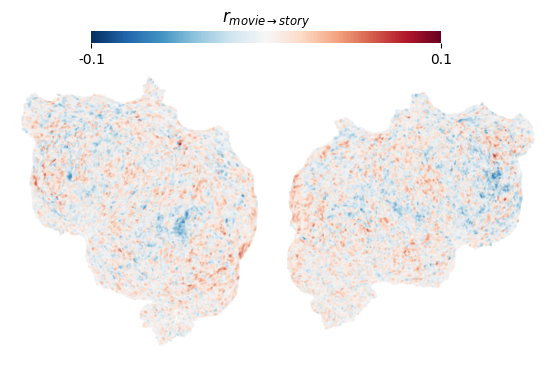

In [38]:
vmin, vmax = -0.1, 0.1
fig, axs = plt.subplots(1, 2, figsize=(7,4))

# Plot the first flatmap
sc1 = axs[0].scatter(s1_lh_vertex_coords[:, 0], s1_lh_vertex_coords[:, 1], c=s1_story_lh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.005)
axs[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling
# axs[0].set_title('Left Hemisphere')
axs[0].set_frame_on(False)
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_yticks([])  # Remove y-axis ticks

# Plot the second flatmap
sc2 = axs[1].scatter(s1_rh_vertex_coords[:, 0], s1_rh_vertex_coords[:, 1], c=s1_story_rh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.005)
axs[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling
# axs[1].set_title('Right Hemisphere')
axs[1].set_frame_on(False)
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_yticks([])  # Remove y-axis ticks

# Adjust layout to make space for the top colorbar
plt.subplots_adjust(top=0.85, wspace=0)

# Add a single horizontal colorbar at the top
cbar_ax = fig.add_axes([0.25, 0.9, 0.5, 0.03])  # Adjust these values as needed [left, bottom, width, height]
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')

# Set the color bar to only display min and max values
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f'{vmin}', f'{vmax}'])

# Remove the color bar box
cbar.outline.set_visible(False)

plt.title(r'$r_{\mathit{movie \rightarrow story}}$')
plt.savefig('results/visuals/s1_movie_story.png', format='png')
plt.show()

#### 3.4.3 Compare to paper results
<img src="literature/s1_movie_story.jpg" width="600">

## 4 Using the language encoding model to predict fMRI responses to movies

### 4.1 Load fMRI data

In [39]:
from bridgetower_functions import remove_nan

In [40]:
s1_train_nan = np.load("data/fmri_data/moviedata/S1/train.npy")
s1_test_nan = np.load("data/fmri_data/moviedata/S1/test.npy")

In [41]:
s1_train = remove_nan(s1_train_nan)
s1_test = remove_nan(s1_test_nan)

fMRI shape: (3600, 81111)
fMRI shape: (270, 81111)


### 4.2 Combine the data for prediction
All the train data are the same size, test data is slightly smaller so we'll do correlation calculation separately

In [42]:
s1_movie_feature_arrays = [train00_transformed, train01_transformed, train02_transformed,
                  train03_transformed, train04_transformed, train05_transformed,
                  train06_transformed, train07_transformed, train08_transformed,
                  train09_transformed, train10_transformed, train11_transformed]

# Combine data
s1_movie_fmri_train = s1_train
s1_movie_fmri_test = s1_test

s1_movie_features_train = np.vstack(s1_movie_feature_arrays)
s1_movie_features_test = test_transformed

### 4.3 Make predictions

In [43]:
s1_movie_predictions_train = np.dot(s1_movie_features_train, language_encoding)
s1_movie_features_train.shape

(3600, 768)

In [44]:
s1_movie_predictions_test = np.dot(s1_movie_features_test, language_encoding)
s1_movie_features_test.shape

(270, 768)

In [45]:
s1_movie_correlations_train = calc_correlation(s1_movie_predictions_train, s1_movie_fmri_train)
s1_movie_correlations_train.shape

NaNs in correlation coefficients: False


(81111,)

In [46]:
s1_movie_correlations_test = calc_correlation(s1_movie_predictions_test, s1_movie_fmri_test)
s1_movie_correlations_test.shape

NaNs in correlation coefficients: False


(81111,)

In [47]:
all_correlations = np.stack((s1_movie_correlations_train, s1_movie_correlations_train, s1_movie_correlations_train,
                             s1_movie_correlations_train, s1_movie_correlations_train, s1_movie_correlations_train,
                             s1_movie_correlations_train, s1_movie_correlations_train, s1_movie_correlations_train,
                             s1_movie_correlations_train, s1_movie_correlations_train, s1_movie_correlations_train,
                             s1_movie_correlations_test))
all_correlations.shape

(13, 81111)

In [48]:
s1_movie_correlations = np.nanmean(all_correlations, axis=0)

In [49]:
np.nanmax(s1_movie_correlations)

0.1202364496836254

### 4.4 Visualize results

#### 4.4.1 Reverse flattening and masking

In [50]:
# Recreate the mask used for flattening (assuming you have access to 's1_movie_train' or similar)
mask = ~np.isnan(s1_train_nan[0])  # Using the first time point as a reference for the mask

# Initialize an empty 3D array with NaNs for the correlation data
s1_movie_reconstructed_correlations = np.full((31, 100, 100), np.nan)

# Flatten the mask to get the indices of the original valid (non-NaN) data points
valid_indices = np.where(mask.flatten())[0]

# Assign the correlation coefficients to their original spatial positions
for index, corr_value in zip(valid_indices, s1_movie_correlations):
    # Convert the 1D index back to 3D index in the spatial dimensions
    z, x, y = np.unravel_index(index, (31, 100, 100))
    s1_movie_reconstructed_correlations[z, x, y] = corr_value

s1_movie_reconstructed_correlations.shape

(31, 100, 100)

In [51]:
s1_movie_flattened_correlations = s1_movie_reconstructed_correlations.flatten()
s1_movie_flattened_correlations.shape

(310000,)

In [52]:
np.nanmax(s1_movie_flattened_correlations)

0.1202364496836254

#### 4.4.2 Plot correlations

In [53]:
s1_movie_lh_vertex_correlation_data = s1_lh_mapping_matrix.dot(s1_movie_flattened_correlations)

In [54]:
s1_movie_rh_vertex_correlation_data = s1_rh_mapping_matrix.dot(s1_movie_flattened_correlations)

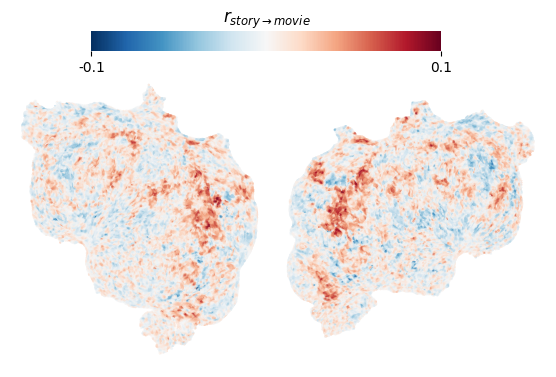

In [55]:
vmin, vmax = -0.1, 0.1
fig, axs = plt.subplots(1, 2, figsize=(7,4))

# Plot the first flatmap
sc1 = axs[0].scatter(s1_lh_vertex_coords[:, 0], s1_lh_vertex_coords[:, 1], c=s1_movie_lh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.02)
axs[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling
# axs[0].set_title('Left Hemisphere')
axs[0].set_frame_on(False)
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_yticks([])  # Remove y-axis ticks

# Plot the second flatmap
sc2 = axs[1].scatter(s1_rh_vertex_coords[:, 0], s1_rh_vertex_coords[:, 1], c=s1_movie_rh_vertex_correlation_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, s=.02)
axs[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling
# axs[1].set_title('Right Hemisphere')
axs[1].set_frame_on(False)
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_yticks([])  # Remove y-axis ticks

# Adjust layout to make space for the top colorbar
plt.subplots_adjust(top=0.85, wspace=0)

# Add a single horizontal colorbar at the top
cbar_ax = fig.add_axes([0.25, 0.9, 0.5, 0.05])  # Adjust these values as needed [left, bottom, width, height]
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
# Set the color bar to only display min and max values
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f'{vmin}', f'{vmax}'])

# Remove the color bar box
cbar.outline.set_visible(False)

plt.title(r'$r_{\mathit{story \rightarrow movie}}$')
plt.savefig('results/visuals/s1_story_movie.png', format='png')
plt.show()

#### 3.4.3 Compare to paper results
<img src="literature/s1_story_movie.jpg" width="600">